In [1]:
import cv2
import pandas as pd
import numpy as np
import scipy 
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmps
import scipy.io as sio
from PIL import Image
import scipy.signal as signal
import pdb
from PIL import Image
import librosa           # Beat detection, BPM analysis
import statistics
import moviepy

## OPTION DICTIONARIES

In [2]:
binary_thresholding_options = {
    '1': cv2.THRESH_BINARY,
    '2': cv2.THRESH_BINARY_INV,
    '3': cv2.THRESH_TRUNC,
    '4': cv2.THRESH_TOZERO,
    '5': cv2.THRESH_TOZERO_INV
}

adaptive_thresholding_options = {
    '1': cv2.ADAPTIVE_THRESH_MEAN_C,
    '2': cv2.ADAPTIVE_THRESH_GAUSSIAN_C
}

colormapChannels = {
    '1': ['Reds', 'Greens', 'Blues'],
    '2': ['YiOrBr', 'PuBuGn', 'Greys']
}

## PROCESSING / FILTERING OF IMAGES

In [3]:
def binaryThresholdingV1(input_path, frame_number, lower_range=177, upper_range=255, thresholdoption='1', colorMap='1'):
    
    """
    Experimental and incomplete. Not compatible with the Image Listing output of video_to_image_array function
    """
    
    cap = cv2.VideoCapture(input_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    res, frame = cap.read()
    imgChannels = []
    
    #fig, axs = plt.subplots(len(frame[0,0]))

    for channel in range(len(frame[0,0])):
        #axs[channel].imshow(cv2.threshold(frame[:,:,channel], lower_range, upper_range, binary_thresholding_options[thresholdoption])[1], cmap=colormapChannels[colorMap][channel]) ### FIND A WAY TO RANDOMISE THE LOWER THRESHOLD 
        imgChannels.append(cv2.threshold(frame[:,:,channel], lower_range, upper_range, binary_thresholding_options[thresholdoption])[1])### FIND A WAY TO RANDOMISE THE LOWER THRESHOLD         
        
    rgb = cv2.merge((imgChannels[0], imgChannels[1], imgChannels[2]))
    return rgb
        ### WITHIN A CERTAIN RANGE 

In [4]:
def binaryThresholdingV2(input_image, frame_number=0, lower_range=177, upper_range=255, thresholdoption='1', colorMap='1', save=False, vis=True):
    
    """
    Newer version intended for use with single individual image 
    """
    
    filePath = ""
    imgChannels = []
    npImage = np.array(input_image)
    for channel in range(len(npImage[0,0])):
        #axs[channel].imshow(cv2.threshold(frame[:,:,channel], lower_range, upper_range, binary_thresholding_options[thresholdoption])[1], cmap=colormapChannels[colorMap][channel]) ### FIND A WAY TO RANDOMISE THE LOWER THRESHOLD 
        imgChannels.append(cv2.threshold(npImage[:,:,channel], lower_range, upper_range, binary_thresholding_options[thresholdoption])[1])### FIND A WAY TO RANDOMISE THE LOWER THRESHOLD         

    rgb = cv2.merge((imgChannels[0], imgChannels[1], imgChannels[2]))

    if save:
        Image.fromarray(rgb).save(f"temp/tempFrame_{frame_number}.jpeg")
        filePath = f"temp/tempFrame_{frame_number}.jpeg"

    if vis:
        axs[image].imshow(rgb)
        axs[image].set_title(f"Lower Threshold Range: {lower_range}, Upper Threshold Range: {upper_range}, Threshold Option: {binary_thresholding_options[thresholdoption]}")
        
    return rgb, filePath

In [5]:
def adaptiveThresholdingV1(input_path, frame_number, upper_range=255, thresholdoption='1'):
    
    """
    Experimental and incomplete. Not compatible with the Image Listing output of video_to_image_array function
    """
    
    cap = cv2.VideoCapture(input_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    res, frame = cap.read()    
    
    fig, axs = plt.subplots(len(frame[0,0]))

    for channel in range(len(frame[0,0])):
        axs[channel].imshow(cv2.adaptiveThreshold(frame[:,:,channel], upper_range, adaptive_thresholding_options[thresholdoption], cv2.THRESH_BINARY, 11, 2), cmap='Reds') ### FIND A WAY TO RANDOMISE THE LOWER THRESHOLD 
        ### WITHIN A CERTAIN RANGE 

In [6]:
def ghosting_effect(frames, alpha=0.7):
    
    prev = None
    for frame in frames:
        if prev is not None:
            frame = cv2.addWeighted(frame, alpha, prev, 1 - alpha, 0)
            prev = frame

## BEAT MATCHING / AUDIO ANALYSIS

In [7]:
def get_audio_report(file_path):
    (sig, rate) = librosa.load(file_path, sr=None)
    tempo, beats = librosa.beat.beat_track(y=sig, sr=rate)
    frames = librosa.frames_to_time(beats, sr=rate)
    
    frame_rate = statistics.mode(frames[i+1] - frames[i] for i in range(len(frames)-1))
    return tempo, beats, frames, frame_rate 

## IMAGE STACK RETRIEVAL METHODS

In [8]:
def extend_image_to_array(file_path, audio_file_path, frame_count, multiplier=2):
    """
    Take one image and duplicate it to a specified number of frames, separate by a 
    frame-rate established by a component piece of audio
    
    """
    
    images = []
    
    #### This bit will change, just acquiring image from market video for ease of use as that's what I have uploaded
    cap = cv2.VideoCapture(file_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, 10)
    res, frame = cap.read()
    im = Image.fromarray(frame)
    
    i = 1
    while i < frame_count:
        images.append(im)
        i += 1
        
    return images
    
    
    

In [9]:
def video_to_image_array(file_path, audio_file_path, frame_interval=1):
    cap = cv2.VideoCapture(file_path)
    cap.get(cv2.CAP_PROP_FRAME_COUNT)
    broken_frames = np.arange(0, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), frame_interval)
    
    if audio_file_path != None: 
        tempo, beats, frames, frame_rate = get_audio_report(audio_file_path)
    
    images = []
    for i in range(len(broken_frames)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, broken_frames[i])
        res, frame = cap.read()
        im = Image.fromarray(frame)
        images.append(im)
        
    return images

In [10]:
def export_video_to_image_array(file_path, audio_file_path, output_file_path, multiplier=2, frame_interval=10):
    cap = cv2.VideoCapture(file_path)
    cap.get(cv2.CAP_PROP_FRAME_COUNT)
    broken_frames = np.arange(0, int(cap.get(cv2.CAP_PROP_FRAME_COUNT)), frame_interval)
    
    tempo, beats, frames, frame_rate = get_audio_report(audio_file_path)
    
    filepaths_list = []
    for i in range(len(broken_frames)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, broken_frames[i])
        res, frame = cap.read()
        im = Image.fromarray(frame).save(f"temp/tempFrame_{i}.jpeg")
        filepaths_list.append(f"temp/tempFrame_{i}.jpeg")
        
    clip = moviepy.ImageSequenceClip([f"{img}" for img in filepaths_list], fps = 1/float(frame_rate) * multiplier)
    clip = clip.set_audio(moviepy.AudioFileClip(audio_file_path))
    clip.write_videofile(output_file_path)

In [20]:
#FINALimageList = video_to_image_array('Video Assets (INPUT)/Supermarket Poplar.mp4', 'Audio Assets (INPUT)/JETPACK VIDEO.wav', frame_interval=1)
INTERIMimageList = video_to_image_array('Video Assets (INPUT)/TEST - PERSON TRACKER SHOREDITCH.mp4', 'Audio Assets (INPUT)/JETPACK VIDEO.wav', frame_interval=2)

#imageList = extend_image_to_array('Video Assets (INPUT)/Supermarket Poplar.mp4', 'Audio Assets (INPUT)/JETPACK VIDEO.wav', 100)
tempo, beats, frames, frame_rate = get_audio_report('Audio Assets (INPUT)/JETPACK VIDEO.wav')

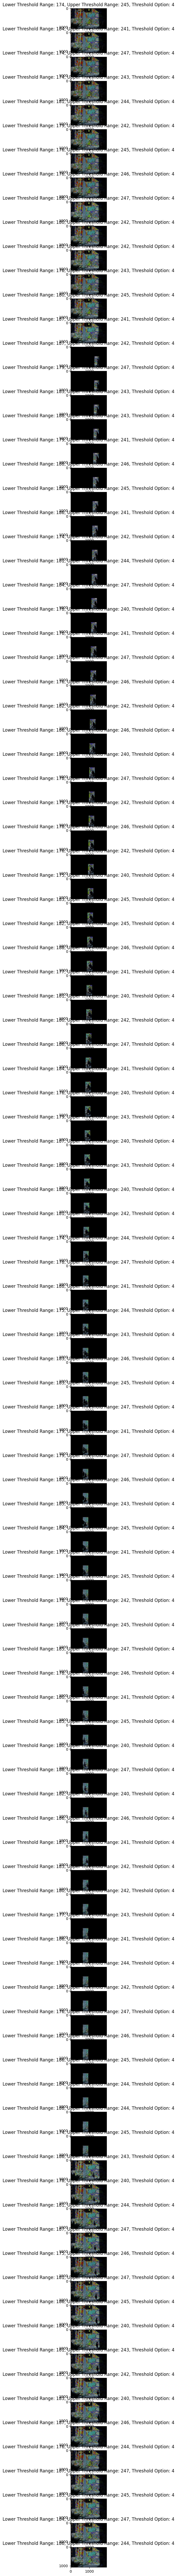

In [21]:
#### ---- GENERIC PRESET TO EXPLORE OPTIONS WITH FULL RANDOMISER ---- ####
# filePaths = []
# fig, axs = plt.subplots(len(imageList), figsize=(128, 128))
# for image in range(len(imageList)):
#     binaryThresholdingV2(imageList[image], lower_range=np.random.randint(140, 189), upper_range=np.random.randint(230, 255), thresholdoption=str(np.random.randint(1, 6)))


#### ---- SAVED PRESET 1 (CABLE STREET MINI SUPERMARKET) ---- ####
filePaths = []
fig, axs = plt.subplots(len(INTERIMimageList), figsize=(128, 128))
for image in range(len(INTERIMimageList)):
    filePaths.append(binaryThresholdingV2(INTERIMimageList[image], frame_number=image, lower_range=np.random.randint(174, 189), upper_range=np.random.randint(240, 248), thresholdoption='5', save=True, vis=True)[1])
    

In [22]:
clip = moviepy.ImageSequenceClip([f"{img}" for img in filePaths], fps = 1/float(frame_rate)*5)
clip.write_videofile('shoreditch.mp4')

MoviePy - Building video shoreditch.mp4.
MoviePy - Writing video shoreditch.mp4



MoviePy - Done !
MoviePy - video ready shoreditch.mp4


#### Next Ideas

#### Chromatic abberation - 

5. Channel Offsets (PSX jitter)

To mimic the PlayStation’s affine texture warping:

Duplicate the layer 2 times.

Set each to target one color channel:

Red layer: keep only red channel active.

Green layer: only green.

Blue layer: only blue.

Slightly nudge each channel (1–3 px) in random directions.

Merge back together.

This creates a subtle RGB “swim” effect.

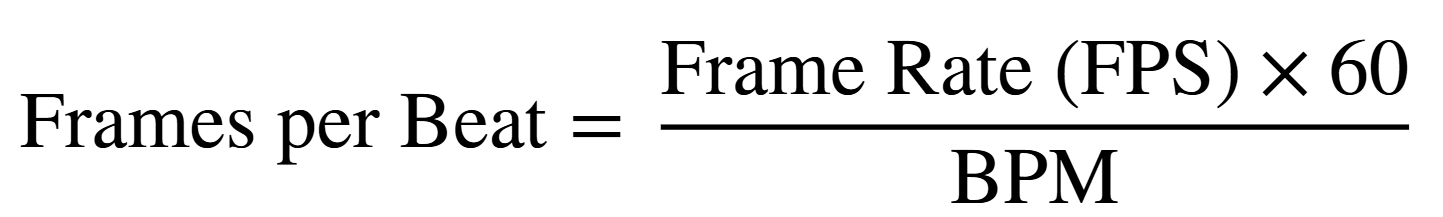